[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/cyneuro/bmtool/blob/master/docs/examples/notebooks/analysis/phase_locking_value/spike_phase_entrainment.ipynb)

# Calculating Phase Locking with BMTool

**By Gregory Glickert**

This notebook demonstrates how to use BMTool to calculate phase locking between spike times and local field potential (LFP) oscillations. We'll explore three different metrics: Phase-Locking Value (PLV), Pairwise Phase Consistency (PPC), and an optimized version (PPC2).

In [1]:
RunningInCOLAB = 'google.colab' in str(get_ipython())
if RunningInCOLAB:
    %pip install bmtool &> /dev/null

In [2]:
import numpy as np
from scipy import signal as ss
import matplotlib.pyplot as plt
from bmtool.analysis.lfp import fit_fooof
from bmtool.analysis.entrainment import calculate_spike_lfp_plv, calculate_ppc, calculate_ppc2
import warnings
warnings.filterwarnings("ignore")


/Users/gregglickert/miniconda3/envs/bmtk/lib/python3.11/site-packages/bmtool/analysis/lfp.py:11: DeprecationWarning: 
The `fooof` package is being deprecated and replaced by the `specparam` (spectral parameterization) package.
This version of `fooof` (1.1) is fully functional, but will not be further updated.
New projects are recommended to update to using `specparam` (see Changelog for details).
  from fooof import FOOOF
--No graphics will be displayed.


In [3]:
np.random.seed(9) # lucky number 9
fs = 1000  # 1 kHz sampling rate
duration = 200  # 200 seconds
t = np.arange(0, duration, 1/fs)

# Define oscillation frequencies
beta_freq = 15  # Hz
gamma_freq = 40  # Hz

# Create a simulated LFP with multiple frequency components
lfp = (0.5 * np.sin(2 * np.pi * gamma_freq * t) + 0.2 * np.sin(2 * np.pi * beta_freq * t) +  0.3 * np.random.randn(len(t)))

# Generate phase information for each frequency
beta_phase = np.angle(ss.hilbert(np.sin(2 * np.pi * beta_freq * t)))
gamma_phase = np.angle(ss.hilbert(np.sin(2 * np.pi * gamma_freq * t)))

# Generate beta-synchronized spikes
# Strong preference for specific beta phase, weak response to gamma
beta_spike_probability = (0.8 * (1 + np.cos(beta_phase - np.pi/4)) + 
                            0.1 * (1 + np.cos(gamma_phase - np.pi/3)))

beta_spike_train = np.random.rand(len(t)) < beta_spike_probability * 0.02
beta_spike_times = t[beta_spike_train]

# Generate gamma-synchronized spikes
# Strong preference for specific gamma phase, weak response to beta
gamma_spike_probability = (0.1 * (1 + np.cos(beta_phase - np.pi/4)) + 
                            0.8 * (1 + np.cos(gamma_phase - np.pi/3)))

gamma_spike_train = np.random.rand(len(t)) < gamma_spike_probability * 0.02
gamma_spike_times = t[gamma_spike_train]

print(f"Generated {len(beta_spike_times)} beta-synchronized spikes")
print(f"Generated {len(gamma_spike_times)} gamma-synchronized spikes")

Generated 3596 beta-synchronized spikes
Generated 3661 gamma-synchronized spikes


## Data Generation

Let's create synthetic data to demonstrate phase locking analysis. We'll generate:

1. **Simulated LFP** with beta (15 Hz) and gamma (40 Hz) oscillations plus noise
2. **Beta-entrained spikes** that preferentially fire at specific beta phases
3. **Gamma-entrained spikes** that preferentially fire at specific gamma phases

This controlled setup allows us to verify that our analysis methods correctly identify the known phase relationships.

## Power Spectral Analysis

We can visualize the frequency content of our simulated LFP to confirm it contains the expected beta (15 Hz) and gamma (40 Hz) oscillations:

                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                        The model was run on the frequency range 3 - 98 Hz                        
                                 Frequency Resolution is 3.91 Hz                                  
                                                                                                  
                            Aperiodic Parameters (offset, exponent):                              
                                         -3.8986, -0.0807                                         
                                                                                                  
                                       2 peaks were found:                                        
          

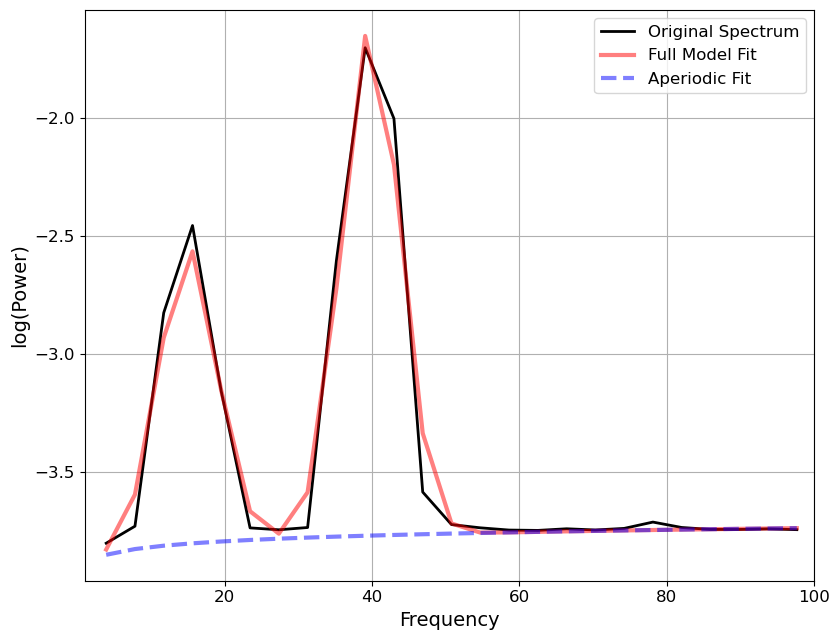

In [4]:
hz,pxx = ss.welch(lfp,fs)
_,_ = fit_fooof(hz,pxx,plot=True,report=True,plt_range=(1,100),freq_range=[1,100])

## Phase Locking Metrics

Now we can analyze how our spike times are entrained to the LFP we created. BMTool provides three different metrics for quantifying phase locking:

### 1. Phase-Locking Value (PLV) - `calculate_spike_lfp_plv`

The **unbiased Phase Locking Value** is calculated through the following steps:

1. **Standard PLV** calculation:
   $$PLV = \left| \frac{1}{N} \sum_{j=1}^{N} e^{i\phi_j} \right|$$
   where $\phi_j$ is the phase at each spike time.

2. **Pairwise Phase Consistency (PPC)** calculation:
   $$PPC = \frac{PLV^2 \cdot N - 1}{N - 1}$$

3. **Unbiased PLV** calculation:
   $$PLV_{unbiased} = \sqrt{\max(PPC, 0)}$$

---

### 2. Pairwise Phase Consistency (PPC) - `calculate_ppc`

PPC calculates phase consistency through pairwise comparisons of spike-phase differences:

$$PPC = \frac{2}{n(n-1)} \sum_{j=1}^{n-1} \sum_{k=j+1}^{n} \cos(\phi_j - \phi_k)$$

Where:
- $\phi_j, \phi_k$ = Phases at spike times $j$ and $k$
- $n$ = Number of spikes

---

### 3. Optimized Pairwise Phase Consistency (PPC2) - `calculate_ppc2`

**PPC2** is an algebraically equivalent but computationally optimized version of PPC.

#### Derivation from PPC:

1. **Original PPC:**
   $$PPC = \frac{2}{n(n-1)} \sum_{i < j} \cos(\phi_i - \phi_j)$$

2. **Rewrite using Euler's formula:**
   $$\cos(\phi_i - \phi_j) = \text{Re}\left( e^{i(\phi_i - \phi_j)} \right)$$

3. **Sum over all pairs:**
   $$\sum_{i < j} \cos(\phi_i - \phi_j) = \frac{1}{2} \sum_{i=1}^n \sum_{j=1}^n \cos(\phi_i - \phi_j) - \frac{n}{2}$$

4. **Express in terms of complex exponentials:**
   $$\sum_{i < j} \cos(\phi_i - \phi_j) = \frac{1}{2} \text{Re} \left( \left| \sum_{j=1}^n e^{i\phi_j} \right|^2 \right) - \frac{n}{2}$$

5. **Final PPC2 formula:**
   $$PPC2 = \frac{\left|\sum_{j=1}^{n} e^{i\phi_j}\right|^2 - n}{n(n-1)}$$

#### Computational advantages of PPC2:
- Converts phases to complex unit vectors
- Uses vector magnitude properties to avoid explicit pairwise comparisons
- Significantly faster for large spike datasets

---

### Key Points:
- All three metrics quantify phase locking between spike times and LFP oscillations
- With sufficient spike times, all metrics should converge to similar values
- PPC2 offers the best computational performance for large datasets

## Demonstration: Calculating Phase Locking Metrics

Let's test all three methods on our gamma-entrained spikes to verify they produce consistent results:

In [5]:
# Demonstrate phase locking calculations for gamma-entrained spikes at 40 Hz
# Note: spikes were generated on second time scale, so spike_fs=1

print("=== Phase Locking Results for Gamma-Entrained Spikes (40 Hz) ===")

# 1. Unbiased PLV (equivalent to square root of PPC)
plv_result = calculate_spike_lfp_plv(
    spike_times=gamma_spike_times, 
    lfp_data=lfp, 
    spike_fs=1, 
    lfp_fs=fs, 
    filter_method='wavelet', 
    freq_of_interest=40
)
print(f"PLV (unbiased): {plv_result:.4f}")

# 2. PPC with different computational methods (all should give identical results)
ppc_numpy = calculate_ppc(
    spike_times=gamma_spike_times, 
    lfp_data=lfp, 
    spike_fs=1, 
    lfp_fs=fs, 
    filter_method='wavelet', 
    freq_of_interest=40, 
    ppc_method='numpy'
)
print(f"√PPC (numpy):   {np.sqrt(ppc_numpy):.4f}")

ppc_numba = calculate_ppc(
    spike_times=gamma_spike_times, 
    lfp_data=lfp, 
    spike_fs=1, 
    lfp_fs=fs, 
    filter_method='wavelet', 
    freq_of_interest=40, 
    ppc_method='numba'
)
print(f"√PPC (numba):   {np.sqrt(ppc_numba):.4f}")

# 3. GPU-accelerated PPC (requires CUDA toolkit and NVIDIA GPU)
try:
    ppc_gpu = calculate_ppc(
        spike_times=gamma_spike_times, 
        lfp_data=lfp, 
        spike_fs=1, 
        lfp_fs=fs, 
        filter_method='wavelet', 
        freq_of_interest=40, 
        ppc_method='gpu'
    )
    print(f"√PPC (GPU):     {np.sqrt(ppc_gpu):.4f}")
except:
    print("√PPC (GPU):     Not available (requires NVIDIA GPU + CUDA)")

# 4. Optimized PPC2 (most efficient for large datasets)
ppc2_result = calculate_ppc2(
    spike_times=gamma_spike_times, 
    lfp_data=lfp, 
    spike_fs=1, 
    lfp_fs=fs, 
    filter_method='wavelet', 
    freq_of_interest=40
)
print(f"√PPC2:          {np.sqrt(ppc2_result):.4f}")

print(f"\nAll methods should produce similar values (~{plv_result:.3f})")

=== Phase Locking Results for Gamma-Entrained Spikes (40 Hz) ===
PLV (unbiased): 0.4253
√PPC (numpy):   0.4253
√PPC (numpy):   0.4253


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


√PPC (numba):   0.4253
√PPC (GPU):     Not available (requires NVIDIA GPU + CUDA)
√PPC2:          0.4253

All methods should produce similar values (~0.425)


## Frequency-Specific Entrainment Analysis

We can also examine entrainment strength across different frequencies to see which oscillations our spike trains are most strongly locked to:

Calculating PPC across frequencies...


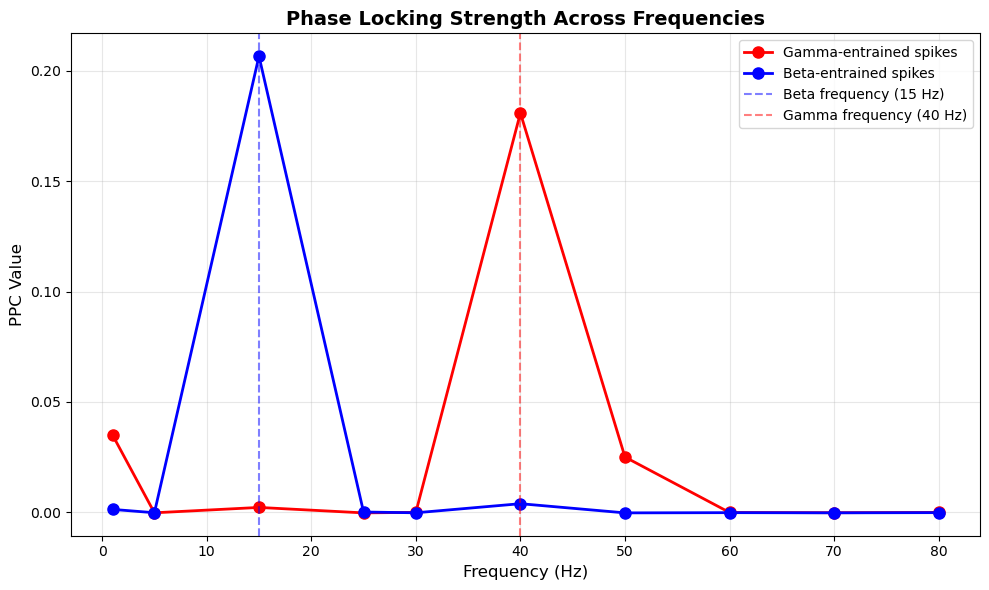


Peak entrainment frequencies:
Gamma spikes: 40 Hz (PPC = 0.1809)
Beta spikes:  15 Hz (PPC = 0.2066)


In [6]:
# Test entrainment across a range of frequencies
freqs = [1, 5, 15, 25, 30, 40, 50, 60, 70, 80]
ppc_gamma = []
ppc_beta = []

print("Calculating PPC across frequencies...")
for freq in freqs:
    # Calculate PPC for gamma-entrained spikes
    ppc_gamma.append(calculate_ppc2(
        spike_times=gamma_spike_times, 
        lfp_data=lfp, 
        spike_fs=1, 
        lfp_fs=fs, 
        filter_method='wavelet', 
        freq_of_interest=freq
    ))
    
    # Calculate PPC for beta-entrained spikes
    ppc_beta.append(calculate_ppc2(
        spike_times=beta_spike_times, 
        lfp_data=lfp, 
        spike_fs=1, 
        lfp_fs=fs, 
        filter_method='wavelet', 
        freq_of_interest=freq
    ))

# Create the frequency entrainment plot
plt.figure(figsize=(10, 6))
plt.plot(freqs, ppc_gamma, 'o-', linewidth=2, markersize=8, 
         label="Gamma-entrained spikes", color='red')
plt.plot(freqs, ppc_beta, 'o-', linewidth=2, markersize=8, 
         label='Beta-entrained spikes', color='blue')

# Add vertical lines to highlight target frequencies
plt.axvline(x=15, color='blue', linestyle='--', alpha=0.5, label='Beta frequency (15 Hz)')
plt.axvline(x=40, color='red', linestyle='--', alpha=0.5, label='Gamma frequency (40 Hz)')

plt.xlabel('Frequency (Hz)', fontsize=12)
plt.ylabel('PPC Value', fontsize=12)
plt.title('Phase Locking Strength Across Frequencies', fontsize=14, fontweight='bold')
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Print peak frequencies for verification
gamma_peak_idx = np.argmax(ppc_gamma)
beta_peak_idx = np.argmax(ppc_beta)
print(f"\nPeak entrainment frequencies:")
print(f"Gamma spikes: {freqs[gamma_peak_idx]} Hz (PPC = {ppc_gamma[gamma_peak_idx]:.4f})")
print(f"Beta spikes:  {freqs[beta_peak_idx]} Hz (PPC = {ppc_beta[beta_peak_idx]:.4f})")

## Summary and Conclusions

This notebook demonstrated how to use BMTool to:

1. **Generate simulated data** with known phase relationships between spikes and LFP oscillations
2. **Calculate phase locking metrics** using three different methods (PLV, PPC, PPC2)
3. **Analyze frequency-specific entrainment** to identify which oscillations drive neural activity

### Key Results:
- **Gamma-entrained spikes** showed strongest phase locking at 40 Hz (gamma frequency)
- **Beta-entrained spikes** showed strongest phase locking at 15 Hz (beta frequency)
- All three metrics (PLV, PPC, PPC2) produced consistent results
- PPC2 provides the most computationally efficient approach for large datasets

### When to Use Each Method:
- **PLV**: Good general-purpose metric, corrected for bias
- **PPC**: Gold standard for phase consistency, computationally intensive
- **PPC2**: Recommended for large datasets due to computational efficiency

BMTool makes it easy to quantify neural entrainment with just a few function calls!